**Reading the Image**

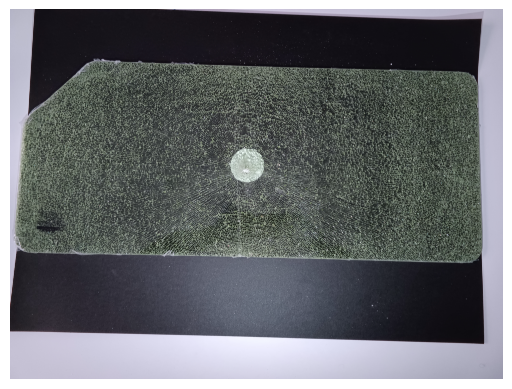

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 

# Read the input image
image = cv2.imread("Input/glass.jpg")

plt.imshow(image)
plt.axis("off")
plt.show()

**1) Cropping the image** 

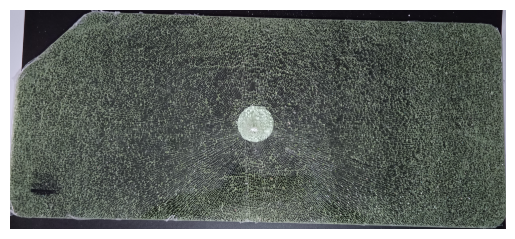

In [2]:
# Convert image to binary format/Grayscale.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur the grayscale image for noise reduction.
gauss_blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Detect the edges in the blurred image using the Canny edge detector.
edged = cv2.Canny(gauss_blurred, 110, 200)

# Create a Rectangle kernel for morphological dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Dilate the edges to thicken them.
mask = cv2.dilate(edged, kernel, iterations=5)

# Find all of the contours in the dilated image
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Find the largest contour in the list of contours. We assume this is the edge surrounding the window.
largest_contour_index = np.argmax([cv2.contourArea(c) for c in contours])
largest_contour = contours[largest_contour_index]

# Get the coordinates of the bounding rectangle of the largest contour.
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the input image using the coordinates of the bounding rectangle.
cropped_image = image[y:y+h, x:x+w]

cv2.imwrite("Output/Cropped Image.png", cropped_image)

plt.imshow(cropped_image)
plt.axis("off")
plt.show()

**Center Circle Removal**

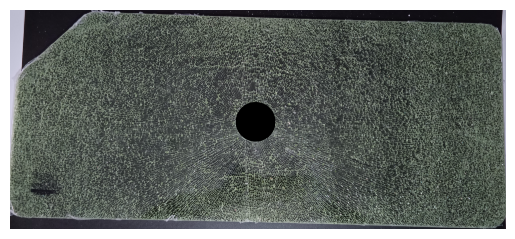

In [3]:
# Convert the cropped image to grayscale
cropped_image_gray= cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

# Heavily blur the image to find center circle. This will make sure that the edges caused by fragmentation are removed by Canny that is implemented inside HoughCircles().
cropped_image_gray = cv2.medianBlur(cropped_image_gray, 101)

# Detect circles in the cropped grayscale image using the HoughCircles() function
circles = cv2.HoughCircles(cropped_image_gray, cv2.HOUGH_GRADIENT, 1, cropped_image_gray.shape[0] / 1, param1=40, param2=30, minRadius=0, maxRadius=0)

# First, check if there are any circles. If there are, then fill the largest circle in black. We assume that is the center circle.
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        radius = i[2]
        cv2.circle(cropped_image, center, radius, (0, 0, 0), cv2.FILLED)

cv2.imwrite("Output/After Circle Removal.png", cropped_image)

plt.imshow(cropped_image)
plt.axis("off")
plt.show()

**Background Removal**

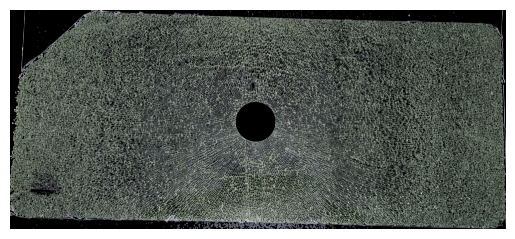

In [4]:
# Convert the cropped and center removed image to grayscale
gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

# Detect edges. Here we want to detect as many fragmentation edges as possible. But we have to be wary of the pixels that are out of the window.
edges = cv2.Canny(gray, threshold1=30, threshold2=100)

# Dilate the fragmentation edges to thicken them.
mask = cv2.dilate(edges, None, iterations=5)

# Convert all the irrelevant pixels to black.
result = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)

plt.show()

cv2.imwrite("Output/Black Background.png",result)

plt.imshow(result)
plt.axis("off")
plt.show()

**Transparentation**

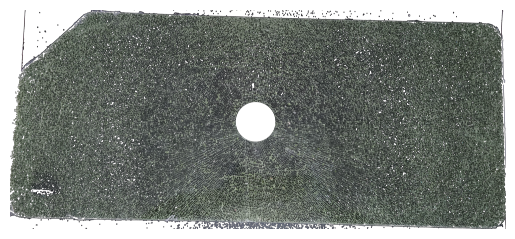

In [5]:
#This process is here because the client wished us to implement it.

# Convert the image to RGBA mode (for transparency)
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)

# Get the pixel data as a list of tuples (B, G, R, A)
pixel_data = list(result.reshape(-1, 4))


# If the sum of the r,g,b channels are lesser than 30, make its alpha channel 0. (fully transparent with alpha=0)
new_pixel_data = [(r, g, b, 0) if sum((r, g, b)) <= 30 else (r, g, b, a) for (r, g, b, a) in pixel_data]

# Reshape the pixel data back to the original image shape
transparent_output = np.array(new_pixel_data, dtype=np.uint8).reshape(result.shape[0], result.shape[1], 4)

cv2.imwrite("Output/Transparent Background.png",transparent_output)

plt.imshow(transparent_output)
plt.axis("off")
plt.show()


**HeatMap**

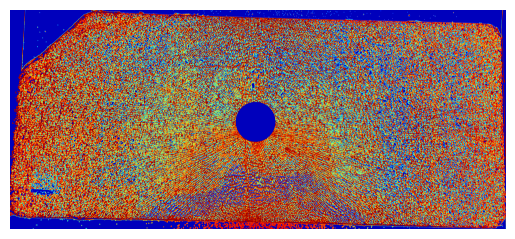

In [6]:
# Apply the colormap to the image (excluding transparent areas)
colored_image = cv2.applyColorMap(transparent_output[:, :, 0], cv2.COLORMAP_JET)

result_image = cv2.addWeighted(colored_image, 1, transparent_output[:, :, :3], 1, 0)

gray = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY)

heatmap = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGRA2RGBA)

plt.imshow(heatmap)
plt.axis("off")
plt.show()

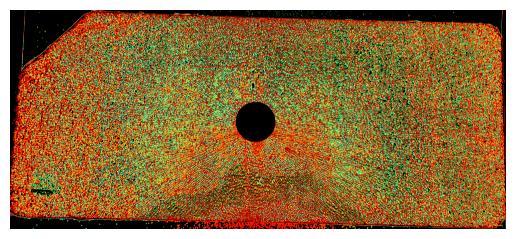

In [7]:
#import PIL library to remove blue background easily.
from PIL import Image

image_array = np.array(heatmap)

# Define the target color (blue in this case) and the color threshold
target_color = np.array([0, 0, 255, 255])  # RGBA color for blue (with alpha channel)
color_threshold = 170  # Adjust this threshold as needed

# Create a mask for the blue pixels based on the threshold
blue_pixels = np.all(np.abs(image_array[:, :, :3] - target_color[:3]) <= color_threshold, axis=-1)

# Set the blue pixels to be transparent (fully transparent with alpha=0)
image_array[blue_pixels, 2] = 0

# Create a new image from the modified array
result_image = Image.fromarray(image_array)

result_image.save('Output/Heatmapped Image.png')

plt.imshow(result_image)
plt.axis("off")
plt.show()